In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
import os
import random

np.random.seed(69)
random.seed(69)
torch.manual_seed(69)
torch.cuda.manual_seed(69)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Data Loading

In [186]:
df = pd.read_csv('pirvision_office_dataset1.csv')

In [187]:
pir_columns = [col for col in df.columns if col.startswith('PIR_')]

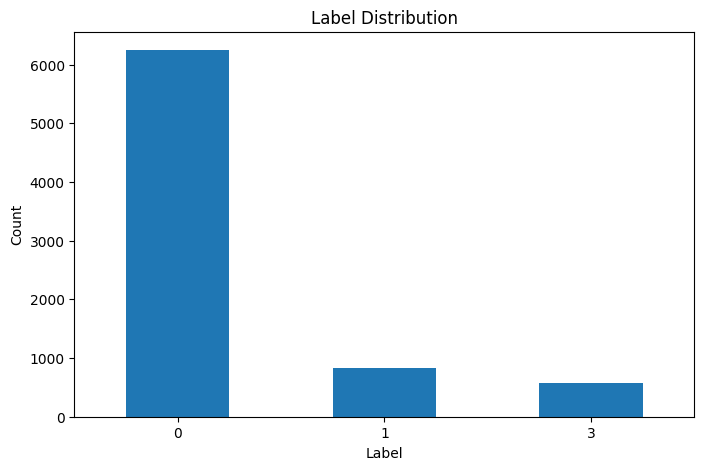

In [188]:
# Label distribution
plt.figure(figsize=(8, 5))
df['Label'].value_counts().plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

The label distribution graph reveals a severely imbalanced dataset, with label 0 dominating (frequency >5000) and labels 1 and 3 being minority classes (frequencies ~1000 and ~800, respectively)

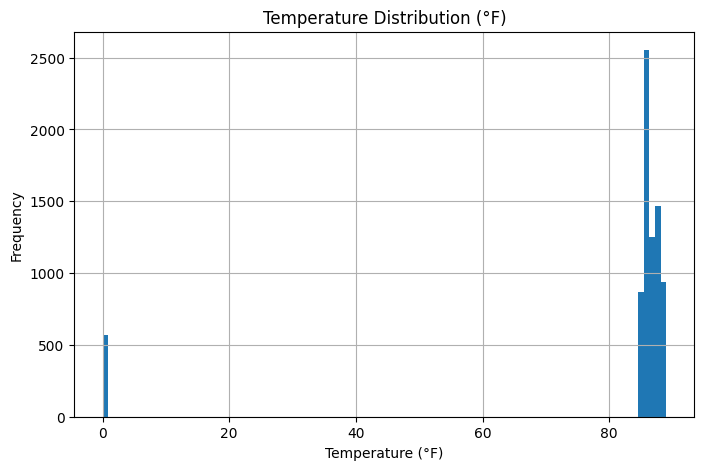

In [189]:
# Temperature distribution
plt.figure(figsize=(8, 5))
df['Temperature_F'].hist(bins=100)
plt.title('Temperature Distribution (°F)')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.show()

The histogram exhibits a strong right-skewed distribution, with a dominant peak at approximately 80°F (frequency exceeding 2000) and a minor peak near 0°F (frequency around 500). This suggests that the majority of temperature readings are clustered around room temperature (likely typical office conditions), with a smaller subset of anomalous or outlier readings at lower temperatures

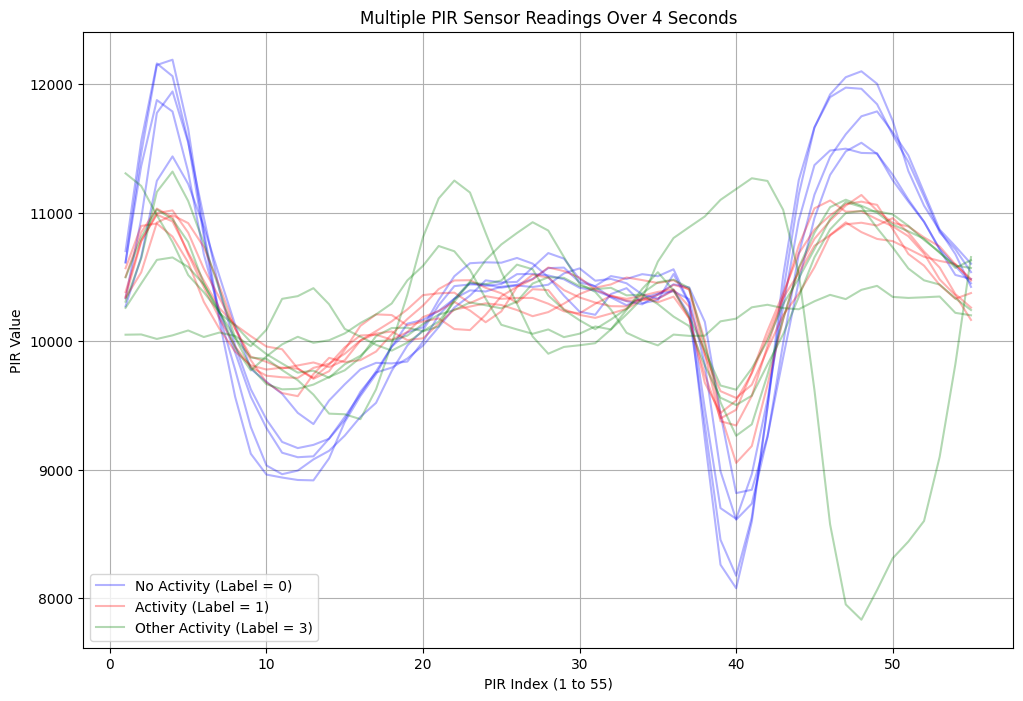

In [190]:
# Plot multiple PIR readings
n_samples = 5
label_0_rows = df[df['Label'] == 0].sample(n=min(n_samples, len(df[df['Label'] == 0])), random_state=42)
label_1_rows = df[df['Label'] == 1].sample(n=min(n_samples, len(df[df['Label'] == 1])), random_state=42) if not df[df['Label'] == 1].empty else pd.dfFrame()
label_3_rows = df[df['Label'] == 3].sample(n=min(n_samples, len(df[df['Label'] == 3])), random_state=42) if not df[df['Label'] == 3].empty else pd.dfFrame()

plt.figure(figsize=(12, 8))
for idx, row in label_0_rows.iterrows():
    plt.plot(range(1, 56), row[pir_columns].values, color='blue', alpha=0.3, label='No Activity (Label = 0)' if idx == label_0_rows.index[0] else "")
if not label_1_rows.empty:
    for idx, row in label_1_rows.iterrows():
        plt.plot(range(1, 56), row[pir_columns].values, color='red', alpha=0.3, label='Activity (Label = 1)' if idx == label_1_rows.index[0] else "")
if not label_3_rows.empty:
    for idx, row in label_3_rows.iterrows():
        plt.plot(range(1, 56), row[pir_columns].values, color='green', alpha=0.3, label='Other Activity (Label = 3)' if idx == label_3_rows.index[0] else "")
plt.title('Multiple PIR Sensor Readings Over 4 Seconds')
plt.xlabel('PIR Index (1 to 55)')
plt.ylabel('PIR Value')
plt.legend()
plt.grid(True)
plt.show()

The three curves (blue for label 0, red for label 1, green for label 3) show different trends over the 55 PIR sensors.Each curve shows fluctuations over the 4-second period, with peaks and troughs at different PIR indices.The PIR values vary significantly across the 55 sensors for each label, with notable peaks (e.g., around indices 10-15 and 40-50 for label 0 and 1, and similar but shifted peaks for label 3). This indicates spatial heterogeneity in sensor responses, suggesting that activity patterns are distributed unevenly across the sensor array.

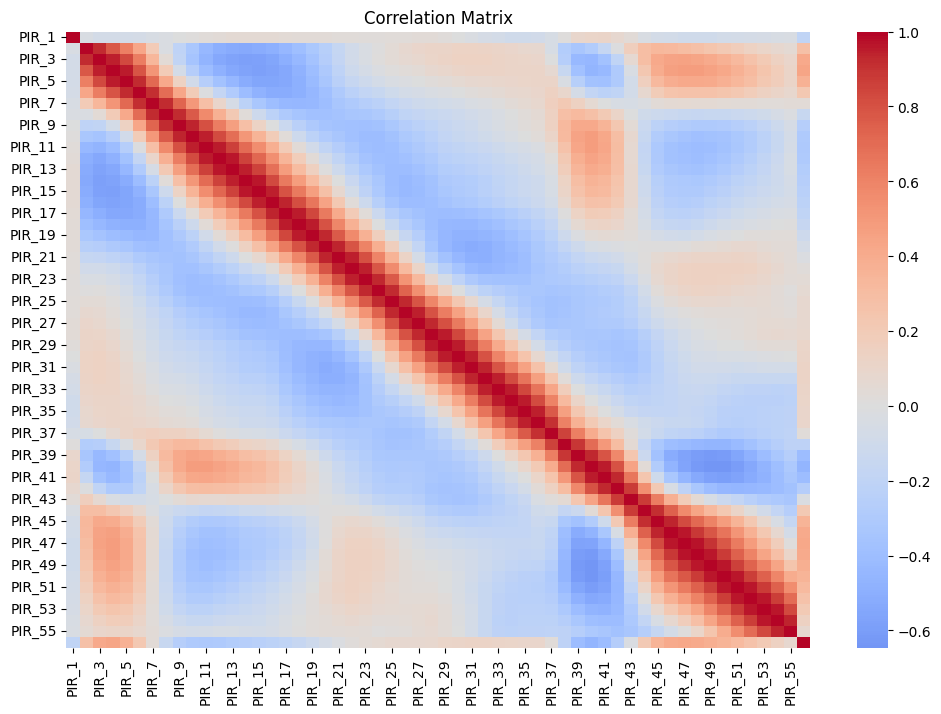

In [191]:
# Correlation matrix for PIR columns
pir_cols = [f'PIR_{i}' for i in range(1, 56)]
corr_matrix = df[pir_cols + ['Temperature_F']].corr()

# Plot heatmap
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

The correlation matrix for the PIR sensor data reveals a strong diagonal pattern, indicating high autocorrelation within each sensor's time series (e.g., PIR_1 with itself, PIR_3 with itself, etc.), with correlation coefficients approaching 1.0. This suggests that each sensor's readings are highly consistent over time, which is expected in PIR data due to continuous monitoring of motion. Off-diagonal correlations show moderate to weak relationships between different sensors (e.g., PIR_1 with PIR_15 or PIR_23), with values ranging from approximately -0.6 to 0.6, indicating some inter-sensor dependencies or spatial interactions in the office environment. The presence of both positive and negative correlations suggests diverse motion patterns or sensor placements

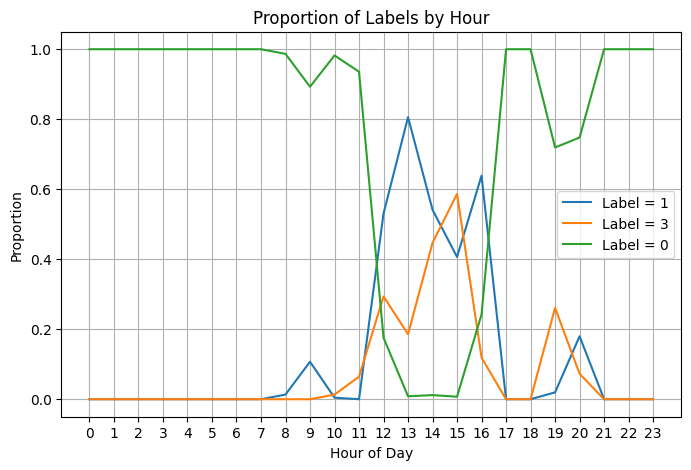

In [192]:
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format="%Y-%m-%d %H:%M:%S")
df['Hour'] = df['Datetime'].dt.hour

hourly_activity_0 = df.groupby(['Date', 'Hour'])['Label'].apply(lambda x: (x == 0).mean()).groupby('Hour').mean()
hourly_activity_1 = df.groupby(['Date', 'Hour'])['Label'].apply(lambda x: (x == 1).mean()).groupby('Hour').mean()
hourly_activity_3 = df.groupby(['Date', 'Hour'])['Label'].apply(lambda x: (x == 3).mean()).groupby('Hour').mean()

plt.figure(figsize=(8, 5))
hourly_activity_1.plot(label='Label = 1')
hourly_activity_3.plot(label='Label = 3')
hourly_activity_0.plot(label='Label = 0')
plt.title('Proportion of Labels by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Proportion')
plt.grid(True)
plt.xticks(range(0, 24))
plt.legend()
plt.show()

Label 0 (green) dominates with a proportion close to 1.0 during early morning (0–6 hours) and late evening (20–23 hours), suggesting periods of low or no occupancy, such as nighttime or off-hours in an office. Label 1 (blue) and Label 3 (orange) show significant activity during daytime hours (8–18 hours), with peaks around midday (12–15 hours), indicating higher occupancy or activity levels, possibly during work hours. The overlapping peaks and troughs suggest dynamic transitions between states

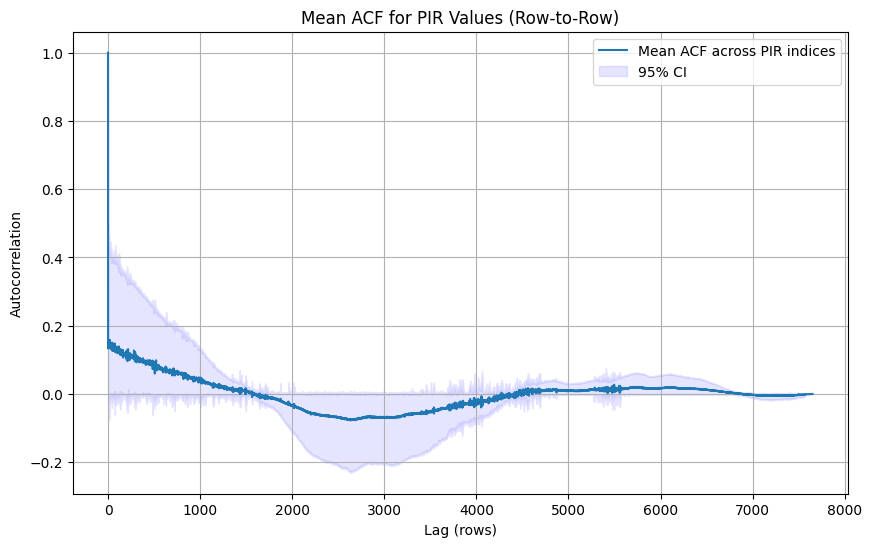

<Figure size 1000x600 with 0 Axes>

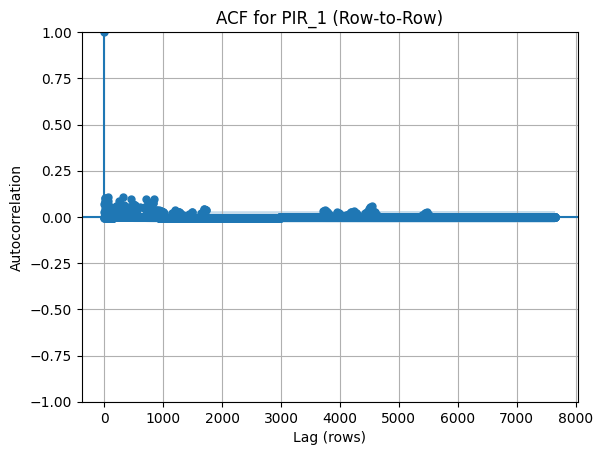

<Figure size 1000x600 with 0 Axes>

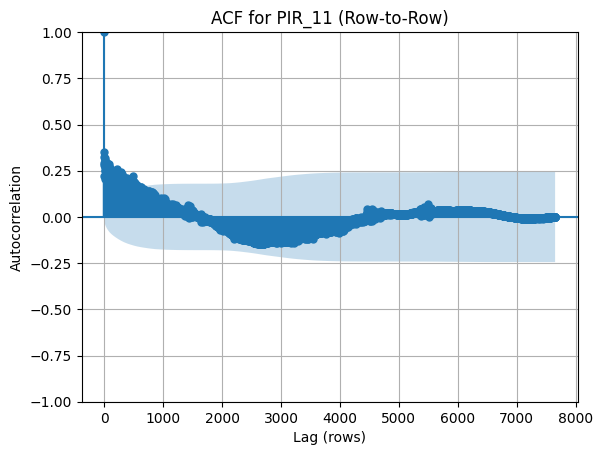

<Figure size 1000x600 with 0 Axes>

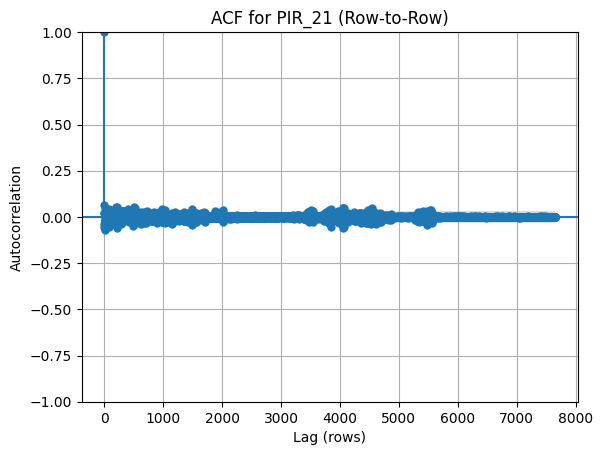

<Figure size 1000x600 with 0 Axes>

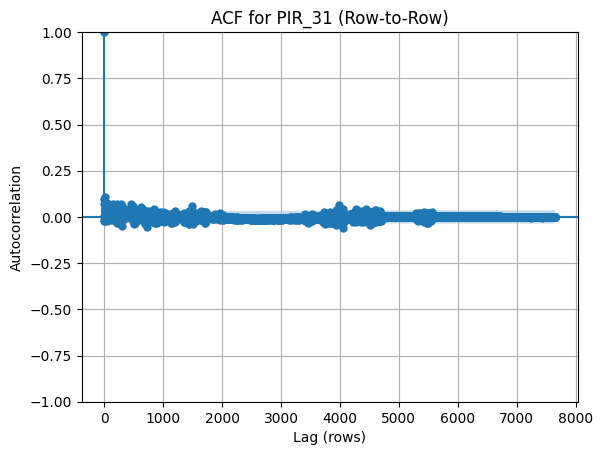

<Figure size 1000x600 with 0 Axes>

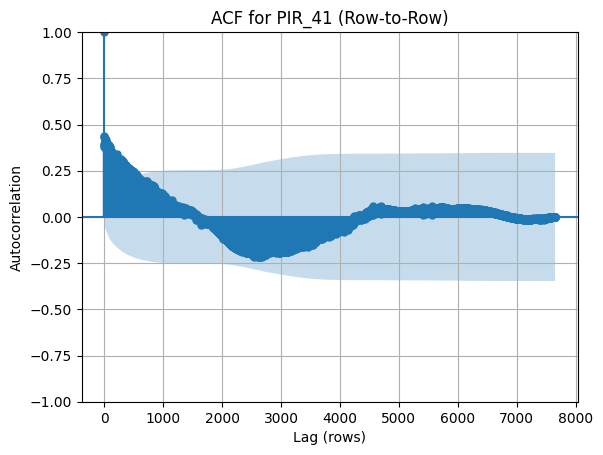

In [ ]:
pir_data = df[pir_columns].values 

n_rows = len(df)
nlags = n_rows - 1 

# Initialize array to store ACF for each PIR index
acf_all_indices = np.zeros((55, nlags + 1))  

for i in range(55):
    acf_all_indices[i, :] = acf(pir_data[:, i], nlags=nlags, alpha=0.05)[0] 

# Compute mean ACF across all 55 indices
mean_acf = np.mean(acf_all_indices, axis=0)
confint_mean = np.percentile(acf_all_indices, [2.5, 97.5], axis=0)  # 95% CI via percentile

# Plot mean ACF
plt.figure(figsize=(10, 6))
plt.plot(mean_acf, label='Mean ACF across PIR indices')
plt.fill_between(range(nlags + 1), confint_mean[0], confint_mean[1], color='blue', alpha=0.1, label='95% CI')
plt.title("Mean ACF for PIR Values (Row-to-Row)")
plt.xlabel("Lag (rows)")
plt.ylabel("Autocorrelation")
plt.legend()
plt.grid(True)
plt.show()

for i in [0, 10, 20, 30, 40]: 
    plt.figure(figsize=(10, 6))
    plot_acf(pir_data[:, i], lags=nlags, title=f"ACF for PIR_{i+1} (Row-to-Row)")
    plt.xlabel("Lag (rows)")
    plt.ylabel("Autocorrelation")
    plt.grid(True)
    plt.show()

The ACF starts near 1.0 at lag 0, indicating perfect correlation with itself, but drops sharply to near 0.0 within the first 1000 lags and remains close to zero with minor fluctuations (ranging from approximately -0.2 to 0.2) for lags up to 8000. The 95% CI consistently includes zero beyond the initial drop, suggesting that there is no significant autocorrelation between rows at larger lags. This indicates that the PIR sensor data lacks long-term temporal dependencies across rows

# Preprocessing

Extracting Date and Time

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Seconds'] = df['Time'].apply(lambda t: t.hour * 3600 + t.minute * 60 + t.second)

Mapping Label 3 to 2

In [ ]:
label_mapping = {0: 0, 1: 1, 3: 2}
df['Label'] = df['Label'].map(label_mapping)
print("Unique labels after mapping:", df['Label'].unique())

Unique labels after mapping: [0 1 2]


In [ ]:
# Extract features
pir_data = df[pir_columns].values
labels = df['Label'].values
temp_data = df['Temperature_F'].values.reshape(-1, 1)
dayofweek = df['DayOfWeek'].values.reshape(-1, 1)
seconds = df['Seconds'].values.reshape(-1, 1)

Normalising the features

In [ ]:
# Normalize features
scaler_pir = StandardScaler()
scaler_temp = StandardScaler()
scaler_day = StandardScaler()
scaler_seconds = StandardScaler()

pir_data = scaler_pir.fit_transform(pir_data)
temp_data = scaler_temp.fit_transform(temp_data)
dayofweek = scaler_day.fit_transform(dayofweek)
seconds = scaler_seconds.fit_transform(seconds)

Converting into multichannel input to support CNN

In [ ]:
# Convert to tensors and combine
pir_data = torch.tensor(pir_data, dtype=torch.float32).unsqueeze(1)  # Shape: (n_rows, 1, n_pir)
temp_data = torch.tensor(temp_data, dtype=torch.float32).unsqueeze(1)  # Shape: (n_rows, 1, 1)
dayofweek = torch.tensor(dayofweek, dtype=torch.float32).unsqueeze(1)  # Shape: (n_rows, 1, 1)
seconds = torch.tensor(seconds, dtype=torch.float32).unsqueeze(1)  # Shape: (n_rows, 1, 1)

# Expand temporal features to match PIR dimensions
temp_data = temp_data.expand(-1, -1, pir_data.shape[2])  # Shape: (n_rows, 1, n_pir)
dayofweek = dayofweek.expand(-1, -1, pir_data.shape[2])  # Shape: (n_rows, 1, n_pir)
seconds = seconds.expand(-1, -1, pir_data.shape[2])  # Shape: (n_rows, 1, n_pir)

# Combine all features
combined_data = torch.cat((pir_data, temp_data, dayofweek, seconds), dim=1)  # Shape: (n_rows, 4, n_pir)
labels = torch.tensor(labels, dtype=torch.long)

In [ ]:
# Train-test split
combined_data, combined_data_test, labels, labels_test = train_test_split(
    combined_data, labels, test_size=0.2, random_state=42, stratify=labels
)

In [ ]:
# Determine number of classes dynamically
unique_labels = np.unique(labels.numpy())
n_classes = len(unique_labels)
if n_classes < 2:
    raise ValueError("At least two unique labels are required for classification.")
print(f"Detected {n_classes} classes: {unique_labels}")

# Calculate class weights for imbalance
class_counts = np.bincount(labels.numpy())
class_weights = 1.0 / (class_counts + 1e-10)  # Avoid division by zero
class_weights = class_weights / class_weights.sum()  # Normalize
class_weights = torch.tensor(class_weights, dtype=torch.float)
if class_weights.shape[0] != n_classes:
    raise ValueError(f"Class weights shape {class_weights.shape[0]} does not match number of classes {n_classes}")


Detected 3 classes: [0 1 2]


In [ ]:
# Move tensors to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
combined_data = combined_data.to(device)
labels = labels.to(device)
combined_data_test = combined_data_test.to(device)
labels_test = labels_test.to(device)
class_weights = class_weights.to(device)

In [ ]:
# Define CNN model
class PIRCNN(nn.Module):
    def __init__(self, n_classes=n_classes):
        super(PIRCNN, self).__init__()
        self.conv1 = nn.Conv1d(4, 16, kernel_size=3, padding=1)  # Updated input channels to 4
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * (pir_data.shape[2] // 4), 128)
        self.fc2 = nn.Linear(128, n_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
# Create directory for checkpoints
os.makedirs('checkpoints', exist_ok=True)

In [ ]:
# K-Fold Cross Validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
models = {'CNN': PIRCNN}
val_results = {name: {'acc': [], 'macro_f1': [], 'precision': [], 'recall': [], 'f1': [], 'cm': []} for name in models}
test_results = {name: {'acc': [], 'macro_f1': [], 'precision': [], 'recall': [], 'f1': [], 'cm': []} for name in models}

# Store metrics for plotting
metrics = {name: {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'train_f1': [], 'val_f1': []} for name in models}


for model_name, model_class in models.items():
    print(f"\nTraining {model_name}...")
    for fold, (train_idx, val_idx) in enumerate(skf.split(combined_data.cpu(), labels.cpu())):
        print(f"Fold {fold + 1}/{n_splits}")
        train_data = combined_data[train_idx]
        train_labels = labels[train_idx]
        val_data = combined_data[val_idx]
        val_labels = labels[val_idx]

        train_loader = DataLoader(TensorDataset(train_data, train_labels), batch_size=32, shuffle=True)
        val_loader = DataLoader(TensorDataset(val_data, val_labels), batch_size=32)
        test_loader = DataLoader(TensorDataset(combined_data_test, labels_test), batch_size=32)

        model = model_class().to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Metrics per epoch for this fold
        fold_train_loss, fold_val_loss = [], []
        fold_train_acc, fold_val_acc = [], []
        fold_train_f1, fold_val_f1 = [], []

        # Training loop
        num_epochs = 50
        for epoch in range(num_epochs):
            model.train()
            train_preds, train_targets = [], []
            train_loss = 0.0
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                train_preds.extend(preds.cpu().numpy())
                train_targets.extend(targets.cpu().numpy())

            train_loss /= len(train_loader)
            train_acc = accuracy_score(train_targets, train_preds)
            train_f1 = f1_score(train_targets, train_preds, average='macro')
            fold_train_loss.append(train_loss)
            fold_train_acc.append(train_acc)
            fold_train_f1.append(train_f1)

            # Validation
            model.eval()
            val_preds, val_targets = [], []
            val_loss = 0.0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()
                    preds = torch.argmax(outputs, dim=1)
                    val_preds.extend(preds.cpu().numpy())
                    val_targets.extend(targets.cpu().numpy())

            val_loss /= len(val_loader)
            val_acc = accuracy_score(val_targets, val_preds)
            val_f1 = f1_score(val_targets, val_preds, average='macro')
            fold_val_loss.append(val_loss)
            fold_val_acc.append(val_acc)
            fold_val_f1.append(val_f1)

            if (epoch + 1) % 20 == 0:
                print(f"Epoch {epoch + 1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
                      f"Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, "
                      f"Train F1={train_f1:.4f}, Val F1={val_f1:.4f}")

        # Save checkpoint
        checkpoint_path = f'checkpoints/{model_name}_fold_{fold + 1}.pth'
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Saved checkpoint: {checkpoint_path}")

        # Store fold metrics
        metrics[model_name]['train_loss'].append(fold_train_loss)
        metrics[model_name]['val_loss'].append(fold_val_loss)
        metrics[model_name]['train_acc'].append(fold_train_acc)
        metrics[model_name]['val_acc'].append(fold_val_acc)
        metrics[model_name]['train_f1'].append(fold_train_f1)
        metrics[model_name]['val_f1'].append(fold_val_f1)

        # Validation results
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(targets.cpu().numpy())

        acc = accuracy_score(all_labels, all_preds)
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)
        cm = confusion_matrix(all_labels, all_preds)

        val_results[model_name]['acc'].append(acc)
        val_results[model_name]['macro_f1'].append(macro_f1)
        val_results[model_name]['precision'].append(precision)
        val_results[model_name]['recall'].append(recall)
        val_results[model_name]['f1'].append(f1)
        val_results[model_name]['cm'].append(cm)

        # Test evaluation
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(targets.cpu().numpy())

        acc = accuracy_score(all_labels, all_preds)
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)
        cm = confusion_matrix(all_labels, all_preds)

        test_results[model_name]['acc'].append(acc)
        test_results[model_name]['macro_f1'].append(macro_f1)
        test_results[model_name]['precision'].append(precision)
        test_results[model_name]['recall'].append(recall)
        test_results[model_name]['f1'].append(f1)
        test_results[model_name]['cm'].append(cm)


Training CNN...
Fold 1/5
Epoch 20: Train Loss=0.0152, Val Loss=0.0829, Train Acc=0.9896, Val Acc=0.9788, Train F1=0.9825, Val F1=0.9655
Epoch 40: Train Loss=0.0125, Val Loss=0.1006, Train Acc=0.9933, Val Acc=0.9861, Train F1=0.9886, Val F1=0.9768
Saved checkpoint: checkpoints/CNN_fold_1.pth
Fold 2/5
Epoch 20: Train Loss=0.0225, Val Loss=0.0283, Train Acc=0.9871, Val Acc=0.9877, Train F1=0.9785, Val F1=0.9790
Epoch 40: Train Loss=0.0184, Val Loss=0.0154, Train Acc=0.9896, Val Acc=0.9902, Train F1=0.9825, Val F1=0.9829
Saved checkpoint: checkpoints/CNN_fold_2.pth
Fold 3/5
Epoch 20: Train Loss=0.0185, Val Loss=0.0368, Train Acc=0.9896, Val Acc=0.9943, Train F1=0.9823, Val F1=0.9900
Epoch 40: Train Loss=0.0176, Val Loss=0.0240, Train Acc=0.9910, Val Acc=0.9886, Train F1=0.9848, Val F1=0.9807
Saved checkpoint: checkpoints/CNN_fold_3.pth
Fold 4/5
Epoch 20: Train Loss=0.0237, Val Loss=0.0290, Train Acc=0.9867, Val Acc=0.9747, Train F1=0.9778, Val F1=0.9600
Epoch 40: Train Loss=0.0248, Val Lo


CNN Validation Results:
Mean Accuracy: 0.9902
Mean Macro F1-Score: 0.9836
Class 0: Precision=0.9982, Recall=0.9898, F1=0.9940
Class 1: Precision=0.9303, Recall=0.9865, F1=0.9569
Class 2: Precision=1.0000, Recall=1.0000, F1=1.0000


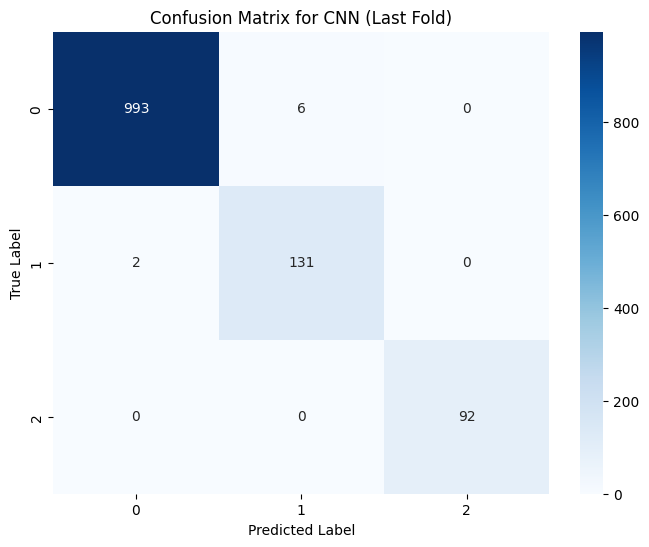


CNN Test Results:
Mean Accuracy: 0.9928
Mean Macro F1-Score: 0.9879
Class 0: Precision=0.9992, Recall=0.9920, F1=0.9956
Class 1: Precision=0.9440, Recall=0.9940, F1=0.9682
Class 2: Precision=1.0000, Recall=1.0000, F1=1.0000


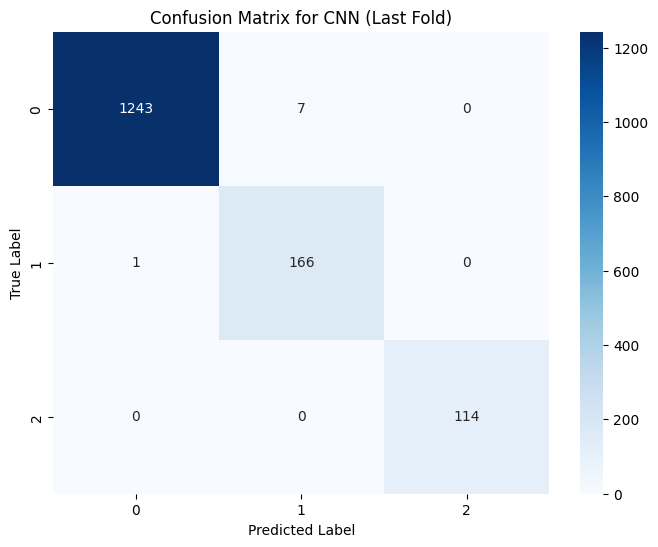

In [ ]:
for model_name in models:
    print(f"\n{model_name} Validation Results:")
    print(f"Mean Accuracy: {np.mean(val_results[model_name]['acc']):.4f}")
    print(f"Mean Macro F1-Score: {np.mean(val_results[model_name]['macro_f1']):.4f}")
    mean_prec = np.mean(val_results[model_name]['precision'], axis=0)
    mean_rec = np.mean(val_results[model_name]['recall'], axis=0)
    mean_f1 = np.mean(val_results[model_name]['f1'], axis=0)
    for i in range(n_classes):
        print(f"Class {i}: Precision={mean_prec[i]:.4f}, Recall={mean_rec[i]:.4f}, F1={mean_f1[i]:.4f}")
    cm = val_results[model_name]['cm'][-1]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name} (Last Fold)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


    print(f"\n{model_name} Test Results:")
    print(f"Mean Accuracy: {np.mean(test_results[model_name]['acc']):.4f}")
    print(f"Mean Macro F1-Score: {np.mean(test_results[model_name]['macro_f1']):.4f}")
    mean_prec = np.mean(test_results[model_name]['precision'], axis=0)
    mean_rec = np.mean(test_results[model_name]['recall'], axis=0)
    mean_f1 = np.mean(test_results[model_name]['f1'], axis=0)
    for i in range(n_classes):
        print(f"Class {i}: Precision={mean_prec[i]:.4f}, Recall={mean_rec[i]:.4f}, F1={mean_f1[i]:.4f}")
    cm = test_results[model_name]['cm'][-1]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name} (Last Fold)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

The misclassification are mostly between class 0 and class 1. It can be because the data distribution of class 0 and class 1 seem similar(peaks at same instances). The models might be finding it difficult to capture the differences among these class distributions.

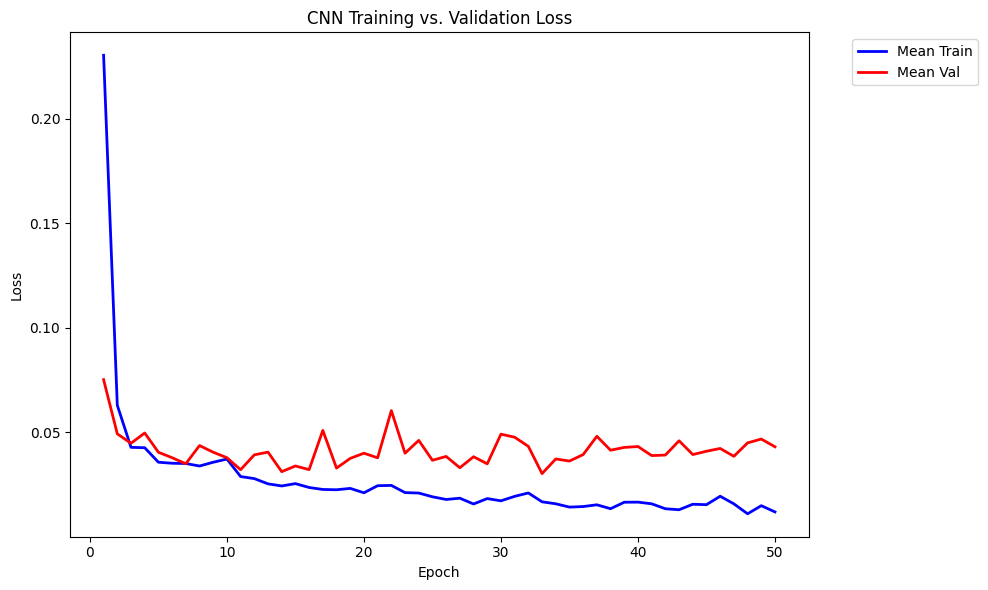

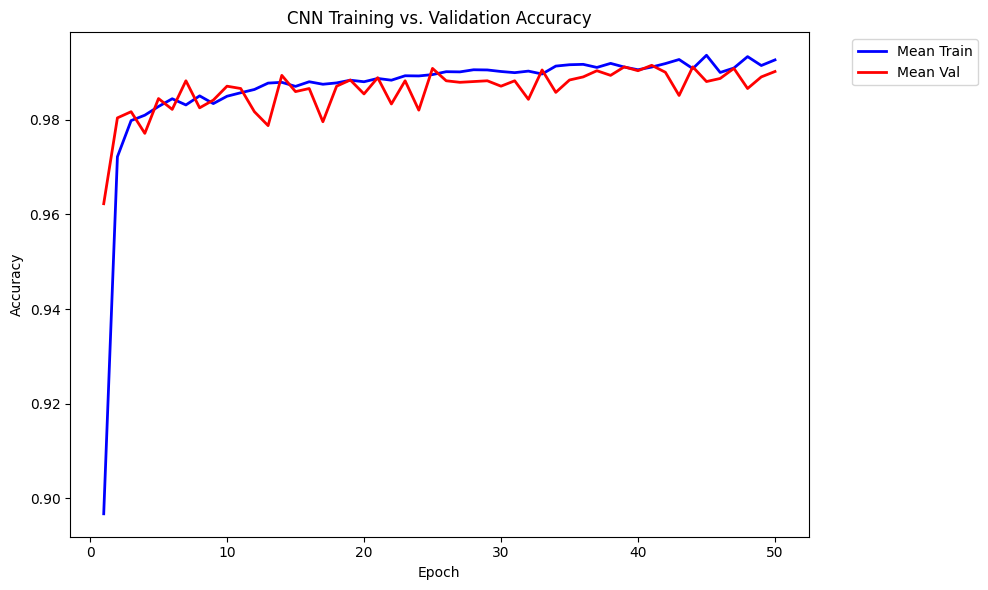

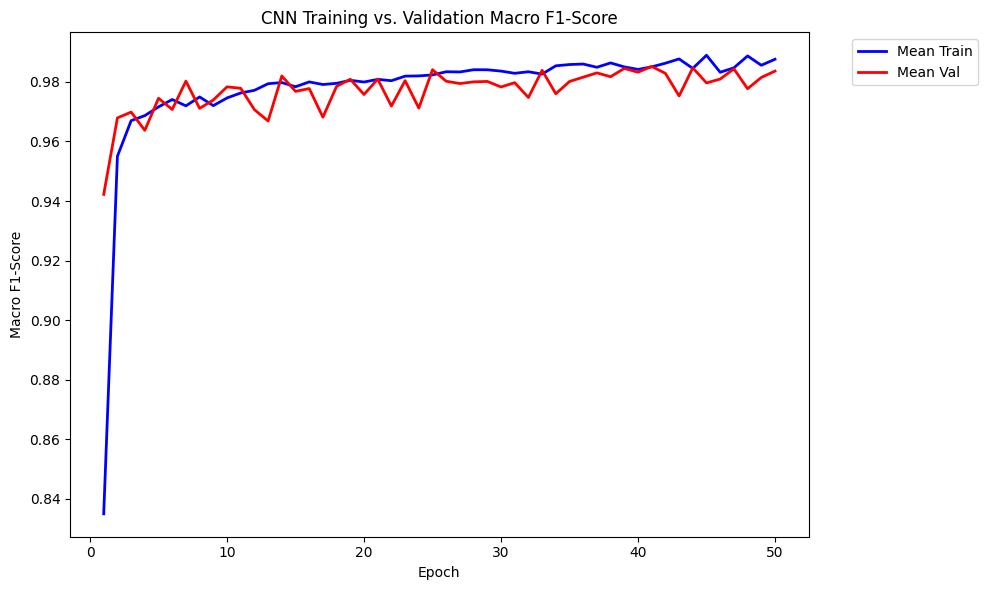

In [ ]:
# Plotting Visualizations
for model_name in models:
    # Convert lists to arrays for easier manipulation
    train_loss = np.array(metrics[model_name]['train_loss'])  # Shape: (n_splits, num_epochs)
    val_loss = np.array(metrics[model_name]['val_loss'])
    train_acc = np.array(metrics[model_name]['train_acc'])
    val_acc = np.array(metrics[model_name]['val_acc'])
    train_f1 = np.array(metrics[model_name]['train_f1'])
    val_f1 = np.array(metrics[model_name]['val_f1'])

    epochs = range(1, num_epochs + 1)

    # 1. Training vs. Validation Loss Curves
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss.mean(axis=0), label='Mean Train', color='blue', linewidth=2)
    plt.plot(epochs, val_loss.mean(axis=0), label='Mean Val', color='red', linewidth=2)
    plt.title(f'{model_name} Training vs. Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 2. Training vs. Validation Accuracy Graphs
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_acc.mean(axis=0), label='Mean Train', color='blue', linewidth=2)
    plt.plot(epochs, val_acc.mean(axis=0), label='Mean Val', color='red', linewidth=2)
    plt.title(f'{model_name} Training vs. Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 3. Training vs. Validation Macro F1-Score Graphs
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_f1.mean(axis=0), label='Mean Train', color='blue', linewidth=2)
    plt.plot(epochs, val_f1.mean(axis=0), label='Mean Val', color='red', linewidth=2)
    plt.title(f'{model_name} Training vs. Validation Macro F1-Score')
    plt.xlabel('Epoch')
    plt.ylabel('Macro F1-Score')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

## Building Model
The model developed for this study is a Convolutional Neural Network (CNN), named PIRCNN, designed to classify office occupancy states based on Passive Infrared (PIR) sensor data, temperature readings, and temporal features (day of the week and time of day). The architecture uses 4 feature channels: normalized PIR sensor readings, temperature, day of the week, and seconds.

## PIRCNN architecture
* Input Layer: Accepts data with shape (batch_size, 4, n_pir), combining normalized PIR sensor data, temperature, and temporal features (4 channels).
* First Convolutional Layer: 1D convolution (nn.Conv1d) with 4 input channels, 16 output channels, kernel size 3, padding 1, followed by ReLU activation.
* First Max Pooling Layer: Max pooling (nn.MaxPool1d) with kernel size 2, halving the feature map length.
* Second Convolutional Layer: 1D convolution with 16 input channels, 32 output channels, kernel size 3, padding 1, followed by ReLU.
* Second Max Pooling Layer: Max pooling with kernel size 2, further reducing feature map length.
* Flattening: Converts output to a 1D vector of size 32 * (n_pir // 4) for dense layers.
* First Fully Connected Layer: Dense layer (nn.Linear) mapping to 128 units, with ReLU activation.
* Dropout Layer: Dropout (nn.Dropout) with 0.3 probability to prevent overfitting.
* Output Layer: Dense layer mapping to n_classes units (e.g., 3 classes: 0, 1, 2), no activation (softmax handled by loss function).

## Training Setup:
* The training process employs a 5-fold Stratified K-Fold Cross-Validation strategy to ensure robust evaluation and mitigate overfitting. The dataset is split into training and testing sets with an 80:20 ratio, using stratified sampling to maintain class distribution. The training set is further divided into five folds, with each fold used once as a validation set while the remaining four serve as the training set.
* Data Loading: Training and validation data are loaded using PyTorch DataLoader with a batch size of 32, shuffling enabled for training to enhance generalization.
* ⁠Model Initialization: A fresh PIRCNN model is instantiated for each fold and moved to the available device (GPU/CPU).
* ⁠Loss Function: Weighted Cross-Entropy Loss is used, with class weights inversely proportional to class frequencies to address imbalance.
* ⁠Optimizer: Adam optimizer with a learning rate of 0.001 is employed for stable and adaptive training.
* ⁠Training Loop: Each fold undergoes 50 epochs, with the model in training mode, computing loss via forward propagation, and updating parameters through backpropagation.

## Cross-Validation:
Stratified K-Fold ensures that each fold preserves the class distribution, critical for imbalanced datasets.
For each fold, the model is trained on four-fifths of the training data and validated on the remaining one-fifth, repeating this process five times to cover all data.
The training process is deterministic, with random seeds set for NumPy, PyTorch, and CUDA (if applicable) to ensure reproducibility.

## Testing Phase
The testing phase evaluates the trained model on both the validation set (within each fold) and the separate test set to assess generalization performance. The evaluation metrics include accuracy, macro F1-score and precision, recall, and F1-score per class, along with confusion matrices to analyze classification errors.

In [ ]:
def evaluate_model(datafile_location, checkpoint):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load model
    model = PIRCNN(n_classes=3).to(device)
    model.load_state_dict(torch.load(checkpoint, map_location=device))
    model.eval()

    # Load CSV
    df = pd.read_csv(datafile_location)

    # Process date/time
    df['Date'] = pd.to_datetime(df['Date'])
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Seconds'] = df['Time'].apply(lambda t: t.hour * 3600 + t.minute * 60 + t.second)

    # Map labels
    label_mapping = {0: 0, 1: 1, 3: 2}
    df['Label'] = df['Label'].map(label_mapping)

    # Extract features
    pir_columns = [col for col in df.columns if col.startswith('PIR_')]
    pir_data = df[pir_columns].values
    temp_data = df['Temperature_F'].values.reshape(-1, 1)
    dayofweek = df['DayOfWeek'].values.reshape(-1, 1)
    seconds = df['Seconds'].values.reshape(-1, 1)
    labels = df['Label'].values

    # Normalize
    pir_data = StandardScaler().fit_transform(pir_data)
    temp_data = StandardScaler().fit_transform(temp_data)
    dayofweek = StandardScaler().fit_transform(dayofweek)
    seconds = StandardScaler().fit_transform(seconds)

    # Convert to tensors
    pir_data = torch.tensor(pir_data, dtype=torch.float32).unsqueeze(1)
    temp_data = torch.tensor(temp_data, dtype=torch.float32).unsqueeze(1).expand(-1, -1, pir_data.shape[2])
    dayofweek = torch.tensor(dayofweek, dtype=torch.float32).unsqueeze(1).expand(-1, -1, pir_data.shape[2])
    seconds = torch.tensor(seconds, dtype=torch.float32).unsqueeze(1).expand(-1, -1, pir_data.shape[2])

    # Combine all
    combined_data = torch.cat((pir_data, temp_data, dayofweek, seconds), dim=1)
    labels = torch.tensor(labels, dtype=torch.long)

    # DataLoader
    dataset = TensorDataset(combined_data, labels)
    loader = DataLoader(dataset, batch_size=64, shuffle=False)

    # Evaluate
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            _, preds = torch.max(outputs, 1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

    accuracy = correct / total
    return accuracy

# Justification of Model Choices

# 1D CNN
* 1D CNNs are excellent at extracting local temporal patterns (e.g., peaks, edges) using convolutional filters.
*  PIR plots show distinct shapes within the 55-value sequence (e.g., high peaks for Label=1), which CNNs can capture effectively with kernels (e.g., size 3–5). 
* The correlation matrix also indicates moderate adjacency correlations, reinforcing the importance of local features.
* CNNs have a fixed receptive field determined by kernel size and pooling, making them faster to train and less prone to vanishing/exploding gradient problems.
* The use of pooling layers and dropout (0.3 in the code) in the CNN helps prevent overfitting, which is critical given the dataset’s skewness and potential noise in PIR readings.With only 55 time steps (representing 4 seconds at ~13.75 Hz), the temporal dependencies are likely short-range, which CNNs can capture with stacked convolutions.
* The addition of temperature as a channel likely benefits CNNs more, as convolutional filters can learn how temperature modulates PIR patterns locally

* ⁠We used grid search for getting the best 
hyperparamters for 1d cnn model. The best hyperparameters we got are : 
  * Number of Convolutional Layers: 2–4
  * Filter Size: 3–5 (temporal kernel size to capture short-term patterns)
  * Number of Filters: 32–128 per layer
  * Pooling: Max-pooling with size 2
  * Dropout: 0.1–0.3
  * Fully Connected Layer Size: 64–256
  * Learning Rate: ~0.0001–0.001
  * Shared Parameters (from notebook):
  * batch_size: 64
  * num_epochs: 100
  * k_folds: 5
  * optimizer: Adam
  * loss_function: CrossEntropyLoss
* ⁠We tried Transformer model as well.
Used grid search to get the best hyperparameters.
  * {'d_model': 128, 'nhead': 16, 'num_layers': 4, 'dim_feedforward': 97, 'dropout': 0.14322263434869237, 'lr': 0.00011465483566985197}
* ⁠At last we feel 1d_cnn is better based on insights gained from data exploration/analysis and also based on compute resources used and time spent.
  * Transformer is taking relatively high compute resources. Considering the size of the dataset, we feel 1d_cnn is better. Transformer seems like an overkill, since there is only slight improvement from using it.

Including time and date features during training resulted in improved accuracy and F1 scores. The dependency between time and labels is also evident in the data analysis section.

Although several other models achieved higher average accuracy, this metric was not considered reliable due to the dominance of label zero over the other two classes. Therefore, class-wise F1 scores and macro F1 scores were more appropriate for evaluation. These metrics were notably higher for the 1D CNN model.

## Transformer model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [ ]:
df1 = pd.read_csv('pirvision_office_dataset1.csv')
# print(df1.head())
# print(df1.info())
# print(df1.describe)

In [ ]:
X = df1.drop(['Label', 'Date'], axis = 1)
y = df1['Label']

In [ ]:
print(df1['Date'].nunique())
print(df1['Time'].nunique())
print(df1['Temperature_F'].nunique())

3
6424
6


In [ ]:
X['hour'] = pd.to_datetime(X['Time'], format='%H:%M:%S').dt.hour
X['minute'] = pd.to_datetime(X['Time'], format='%H:%M:%S').dt.minute
X['second'] = pd.to_datetime(X['Time'], format='%H:%M:%S').dt.second

In [ ]:
# Normalizing.  global normalization for pir values. col norm for temp
from sklearn.preprocessing import StandardScaler, LabelEncoder

pir_columns = [col for col in X.columns if 'PIR' in col]
temp_column = 'Temperature_F'
time_columns = ['hour', 'minute', 'second']

pir_scaler = StandardScaler()
temp_scaler = StandardScaler()
time_scaler = StandardScaler()

X[pir_columns] = pir_scaler.fit_transform(X[pir_columns])
X[[temp_column]] = temp_scaler.fit_transform(X[[temp_column]])
X[time_columns] = time_scaler.fit_transform(X[time_columns])

le = LabelEncoder()
y = le.fit_transform(y)

for index, label in enumerate(le.classes_):
    print(f"{label} --> {index}")

0 --> 0
1 --> 1
3 --> 2


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# Reshape data into (samples, timesteps, features)
X_trans  = X[pir_columns].values.reshape((X.shape[0], 55, 1))
temp_feature = np.repeat(X[[temp_column]].values[:, np.newaxis], 55, axis = 1)
hour_feature = np.repeat(X[['hour']].values[:, np.newaxis], 55, axis = 1)
minute_feature = np.repeat(X[['minute']].values[:, np.newaxis], 55, axis = 1)
second_feature = np.repeat(X[['second']].values[:, np.newaxis], 55, axis = 1)


X_trans = np.concatenate([X_trans, temp_feature, hour_feature, minute_feature, second_feature], axis=2)

#split and prepare data for model training
X_train, X_test, y_train, y_test = train_test_split(X_trans, y, test_size=0.2, random_state=42)

# X_train = X_trans
# y_train = y

# pytoch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [ ]:
# Count number of samples per class
num_samples = y_train.shape[0]
unique_classes, counts = torch.unique(y_train, return_counts=True)

# Calculate percentages
percentages = counts.float() / num_samples * 100

# Display results
for cls, count, pct in zip(unique_classes, counts, percentages):
    print(f"Class {cls.item()}: {count.item()} samples ({pct:.2f}%)")

print(f"Total samples: {num_samples}")

Class 0: 5004 samples (81.76%)
Class 1: 674 samples (11.01%)
Class 2: 442 samples (7.22%)
Total samples: 6120


In [ ]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=55):
        super(PositionalEncoding, self).__init__()

        # Create constant 'pe' matrix with values dependent on pos and i
        pe = torch.zeros(max_len, d_model)  # (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Apply sine to even indices and cosine to odd indices
        pe[:, 0::2] = torch.sin(position * div_term)  # even
        pe[:, 1::2] = torch.cos(position * div_term)  # odd

        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (batch_size, seq_len, d_model)
        x = x + self.pe[:, :x.size(1), :]
        return x

class TransformerClassifier(nn.Module):
    def __init__(self, input_size=5, num_classes=3, d_model=64, nhead=4, num_layers=4, dim_feedforward=128, dropout=0.1, max_len=55):
        super(TransformerClassifier, self).__init__()

        self.embedding = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_len)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        # x: (batch_size, seq_len, input_size)
        x = self.embedding(x)                  # (batch_size, seq_len, d_model)
        x = self.pos_encoder(x)                # Add positional encoding
        x = self.transformer_encoder(x)        # (batch_size, seq_len, d_model)
        out = x[:, -1, :]                      # Take output of the last time step
        logits = self.classifier(out)          # (batch_size, num_classes)
        return logits

In [ ]:
# Duplicating Samples
from torch.utils.data import ConcatDataset, Subset

# Split your dataset into class-wise subsets
class_0_indices = [i for i, label in enumerate(y_train) if label == 0]
class_1_indices = [i for i, label in enumerate(y_train) if label == 1]
class_2_indices = [i for i, label in enumerate(y_train) if label == 2]

# Create subsets
dataset_class_0 = Subset(train_dataset, class_0_indices)
dataset_class_1 = Subset(train_dataset, class_1_indices)
dataset_class_2 = Subset(train_dataset, class_2_indices)

# Duplicate Class 1 and 2 to match Class 0
factor_class_1 = 6247 // 833
factor_class_2 = 6247 // 571

dataset_class_1_upsampled = ConcatDataset([dataset_class_1] * factor_class_1)
dataset_class_2_upsampled = ConcatDataset([dataset_class_2] * factor_class_2)

# Combine all
balanced_dataset = ConcatDataset([dataset_class_0, dataset_class_1_upsampled, dataset_class_2_upsampled])

In [ ]:
from collections import Counter

# Convert tensor labels to integers
labels_balanced = [int(balanced_dataset[i][1]) for i in range(len(balanced_dataset))]

# Count samples per class
class_counts = Counter(labels_balanced)

# Print results
for label, count in class_counts.items():
    print(f"Class {label}: {count} samples")


Class 0: 5004 samples
Class 1: 4718 samples
Class 2: 4420 samples


In [ ]:
pip install optuna

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Your TransformerClassifier and PositionalEncoding class definitions should be here

# --- Training Loop ---
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for batch_x, batch_y in dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss / len(dataloader)

# --- Evaluation Loop ---
def evaluate(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x = batch_x.to(device)
            outputs = model(batch_x)
            preds = torch.argmax(outputs, dim=1).cpu()
            all_preds.extend(preds.numpy())
            all_labels.extend(batch_y.numpy())

    return accuracy_score(all_labels, all_preds)

# --- Optuna Objective Function ---
def objective(trial):
    # Hyperparameters to tune
    d_model = trial.suggest_categorical("d_model", [16, 32, 64, 128, 256])
    nhead = trial.suggest_categorical("nhead", [2, 4, 8, 16])
    num_layers = trial.suggest_int("num_layers", 1, 6)
    dim_feedforward = trial.suggest_int("dim_feedforward", 64, 256)
    dropout = trial.suggest_float("dropout", 0.1, 0.3)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = TransformerClassifier(
        input_size=5,
        num_classes=3,
        d_model=d_model,
        nhead=nhead,
        num_layers=num_layers,
        dim_feedforward=dim_feedforward,
        dropout=dropout,
        max_len=55
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    EPOCHS = 10  # You can increase for better tuning
    for epoch in range(EPOCHS):
        train_loss = train(model, train_loader, criterion, optimizer, device)

    val_acc = evaluate(model, test_loader, device)
    return 1.0 - val_acc  # minimize error

# --- Run Optuna Study ---
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)  # Increase n_trials for better search

# --- Best Hyperparameters ---
print("Best trial:")
print(study.best_trial)
print("Best hyperparameters:")
print(study.best_trial.params)

[I 2025-04-13 17:10:29,340] A new study created in memory with name: no-name-459292fb-6496-4fa6-b989-aed0925ecf89
[I 2025-04-13 17:10:43,446] Trial 0 finished with value: 0.00849118223383405 and parameters: {'d_model': 128, 'nhead': 16, 'num_layers': 3, 'dim_feedforward': 142, 'dropout': 0.11590996101267576, 'lr': 0.0007426789576666932}. Best is trial 0 with value: 0.00849118223383405.
[I 2025-04-13 17:10:50,216] Trial 1 finished with value: 0.014369693011103801 and parameters: {'d_model': 32, 'nhead': 16, 'num_layers': 1, 'dim_feedforward': 172, 'dropout': 0.25934368465470686, 'lr': 0.00269115607634179}. Best is trial 0 with value: 0.00849118223383405.
[I 2025-04-13 17:11:14,570] Trial 2 finished with value: 0.02286087524493796 and parameters: {'d_model': 16, 'nhead': 2, 'num_layers': 6, 'dim_feedforward': 123, 'dropout': 0.20963710291385806, 'lr': 0.00023875974063980587}. Best is trial 0 with value: 0.00849118223383405.
[I 2025-04-13 17:11:24,868] Trial 3 finished with value: 0.02286

Best trial:
FrozenTrial(number=14, state=1, values=[0.005878510777269752], datetime_start=datetime.datetime(2025, 4, 13, 17, 14, 26, 636463), datetime_complete=datetime.datetime(2025, 4, 13, 17, 14, 44, 397402), params={'d_model': 128, 'nhead': 16, 'num_layers': 4, 'dim_feedforward': 97, 'dropout': 0.14322263434869237, 'lr': 0.00011465483566985197}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'d_model': CategoricalDistribution(choices=(16, 32, 64, 128, 256)), 'nhead': CategoricalDistribution(choices=(2, 4, 8, 16)), 'num_layers': IntDistribution(high=6, log=False, low=1, step=1), 'dim_feedforward': IntDistribution(high=256, log=False, low=64, step=1), 'dropout': FloatDistribution(high=0.3, log=False, low=0.1, step=None), 'lr': FloatDistribution(high=0.01, log=True, low=0.0001, step=None)}, trial_id=14, value=None)
Best hyperparameters:
{'d_model': 128, 'nhead': 16, 'num_layers': 4, 'dim_feedforward': 97, 'dropout': 0.14322263434869237, 'lr': 0.0001146548356698

In [ ]:
pip install --upgrade sympy

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
from torch.utils.data import DataLoader, Subset
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, precision_recall_fscore_support, confusion_matrix

# train_dataset = TensorDataset(X_train, y_train)

k_folds = 5
num_epochs = 100
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
# kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

fold_train_accuracies = []
fold_train_f1s = []

fold_val_accuracies = []
fold_val_f1s = []

# Optional: for per-class averages
fold_val_precisions = []
fold_val_recalls = []
fold_val_class_f1s = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(balanced_dataset)):
    print(f"\n--- Fold {fold+1} ---")

    train_subset = Subset(balanced_dataset, train_idx)
    val_subset = Subset(balanced_dataset, val_idx)

    train_loader_n = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader_n = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # {'d_model': 64, 'nhead': 4, 'num_layers': 3, 'dim_feedforward': 227, 'dropout': 0.18793234967062586, 'lr': 0.00012520731444790392}
    # model = LSTMModel().to(device)
    model = TransformerClassifier(5, 3, 128, 16, 4, 97, 0.14322263434869237, 55).to(device)

    # y_sub = y_train[train_idx]
    # class_weights = compute_class_weight(class_weight='balanced',
    #                                  classes=np.unique(y_sub.numpy()),
    #                                  y=y_sub.numpy())
    # class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    # criterion = nn.CrossEntropyLoss(weight=class_weights)

    criterion = nn.CrossEntropyLoss()


    optimizer = torch.optim.Adam(model.parameters(), lr=0.00011465483566985197)

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader_n:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Training set evaluation
    model.eval()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    train_preds = []
    train_labels = []

    with torch.no_grad():
        for X_batch, y_batch in train_loader_n:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            train_total += y_batch.size(0)
            train_correct += (predicted == y_batch).sum().item()

            train_preds.extend(predicted.cpu().numpy())
            train_labels.extend(y_batch.cpu().numpy())

    avg_train_loss = train_loss / len(train_loader_n)
    train_accuracy = train_correct / train_total * 100

    train_preds = np.array(train_preds)
    train_labels = np.array(train_labels)

    train_macro_f1 = f1_score(train_labels, train_preds, average='macro')
    train_class_metrics = precision_recall_fscore_support(train_labels, train_preds, zero_division=0)
    train_conf_matrix = confusion_matrix(train_labels, train_preds)

    # Training set metrics
    print(f"\nTraining Summary for Fold [{fold+1}]:")
    print(f"Train Loss: {avg_train_loss:.4f} | "
          f"Train Acc: {train_accuracy:.2f}% | "
          f"Macro F1: {train_macro_f1:.4f}")

    print("\nTrain Class-wise Precision, Recall, F1:")
    for i, (p, r, f) in enumerate(zip(*train_class_metrics[:3])):
        print(f"Class {i}: Precision={p:.2f}, Recall={r:.2f}, F1={f:.2f}")

    print("\nTrain Confusion Matrix:")
    print(train_conf_matrix)


    # Validation after training (once per fold)
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_val, y_val in val_loader_n:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += y_val.size(0)
            correct += (predicted == y_val).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_val.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader_n)
    val_accuracy = correct / total * 100

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    class_metrics = precision_recall_fscore_support(all_labels, all_preds, zero_division=0)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Train metrics
    fold_train_accuracies.append(train_accuracy)
    fold_train_f1s.append(train_macro_f1)

    # Validation metrics
    fold_val_accuracies.append(val_accuracy)
    fold_val_f1s.append(macro_f1)

    # Optional per-class metrics
    fold_val_precisions.append(class_metrics[0])
    fold_val_recalls.append(class_metrics[1])
    fold_val_class_f1s.append(class_metrics[2])

    # Final fold metrics
    print(f"\nFold [{fold+1}] Summary after {num_epochs} epochs:")
    print(f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {val_accuracy:.2f}% | "
          f"Macro F1: {macro_f1:.4f}")

    print("\nClass-wise Precision, Recall, F1:")
    for i, (p, r, f) in enumerate(zip(*class_metrics[:3])):
        print(f"Class {i}: Precision={p:.2f}, Recall={r:.2f}, F1={f:.2f}")

    print("\nConfusion Matrix:")
    print(conf_matrix)



--- Fold 1 ---

Training Summary for Fold [1]:
Train Loss: 0.0002 | Train Acc: 99.99% | Macro F1: 0.9999

Train Class-wise Precision, Recall, F1:
Class 0: Precision=1.00, Recall=1.00, F1=1.00
Class 1: Precision=1.00, Recall=1.00, F1=1.00
Class 2: Precision=1.00, Recall=1.00, F1=1.00

Train Confusion Matrix:
[[3986    1    0]
 [   0 3790    0]
 [   0    0 3536]]

Fold [1] Summary after 100 epochs:
Val Loss: 0.0057 | Val Acc: 99.86% | Macro F1: 0.9986

Class-wise Precision, Recall, F1:
Class 0: Precision=1.00, Recall=1.00, F1=1.00
Class 1: Precision=1.00, Recall=1.00, F1=1.00
Class 2: Precision=1.00, Recall=1.00, F1=1.00

Confusion Matrix:
[[1013    4    0]
 [   0  928    0]
 [   0    0  884]]

--- Fold 2 ---

Training Summary for Fold [2]:
Train Loss: 0.0002 | Train Acc: 100.00% | Macro F1: 1.0000

Train Class-wise Precision, Recall, F1:
Class 0: Precision=1.00, Recall=1.00, F1=1.00
Class 1: Precision=1.00, Recall=1.00, F1=1.00
Class 2: Precision=1.00, Recall=1.00, F1=1.00

Train Confu

In [ ]:
import numpy as np

print("\n=== Cross-Validation Summary ===")
print(f"Average Train Accuracy: {np.mean(fold_train_accuracies):.4f}%")
print(f"Average Train Macro F1: {np.mean(fold_train_f1s):.4f}")
print(f"Average Val Accuracy: {np.mean(fold_val_accuracies):.4f}%")
print(f"Average Val Macro F1: {np.mean(fold_val_f1s):.4f}")

# Optional: per-class metrics
avg_precisions = np.mean(fold_val_precisions, axis=0)
avg_recalls = np.mean(fold_val_recalls, axis=0)
avg_class_f1s = np.mean(fold_val_class_f1s, axis=0)

print("\nAverage Class-wise Metrics (Validation):")
for i, (p, r, f) in enumerate(zip(avg_precisions, avg_recalls, avg_class_f1s)):
    print(f"Class {i}: Precision={p:.4f}, Recall={r:.4f}, F1={f:.4f}")


=== Cross-Validation Summary ===
Average Train Accuracy: 99.9699%
Average Train Macro F1: 0.9997
Average Val Accuracy: 99.7030%
Average Val Macro F1: 0.9971

Average Class-wise Metrics (Validation):
Class 0: Precision=1.0000, Recall=0.9916, F1=0.9958
Class 1: Precision=0.9914, Recall=1.0000, F1=0.9957
Class 2: Precision=0.9998, Recall=1.0000, F1=0.9999


In [ ]:
# Test test eval
model.eval()
val_loss = 0.0
correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for X_val, y_val in test_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        outputs = model(X_val)
        loss = criterion(outputs, y_val)
        val_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += y_val.size(0)
        correct += (predicted == y_val).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_val.cpu().numpy())

avg_val_loss = val_loss / len(test_loader)
val_accuracy = correct / total * 100

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

macro_f1 = f1_score(all_labels, all_preds, average='macro')
class_metrics = precision_recall_fscore_support(all_labels, all_preds, zero_division=0)
conf_matrix = confusion_matrix(all_labels, all_preds)

# Final fold metrics
# print(f"\nFold [{fold+1}] Summary after {num_epochs} epochs:")
print(f"Val Loss: {avg_val_loss:.4f} | "
      f"Val Acc: {val_accuracy:.4f}% | "
      f"Macro F1: {macro_f1:.4f}")

print("\nClass-wise Precision, Recall, F1:")
for i, (p, r, f) in enumerate(zip(*class_metrics[:3])):
    print(f"Class {i}: Precision={p:.4f}, Recall={r:.4f}, F1={f:.4f}")

print("\nConfusion Matrix:")
print(conf_matrix)

Val Loss: 0.0572 | Val Acc: 99.0202% | Macro F1: 0.9825

Class-wise Precision, Recall, F1:
Class 0: Precision=0.9960, Recall=0.9920, F1=0.9940
Class 1: Precision=0.9390, Recall=0.9686, F1=0.9536
Class 2: Precision=1.0000, Recall=1.0000, F1=1.0000

Confusion Matrix:
[[1233   10    0]
 [   5  154    0]
 [   0    0  129]]
